In [1]:
import numpy as np
import os
from scipy import stats
import pandas as pd
from numpy import loadtxt
import json
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import scipy.stats as st
from scipy.stats import kstest, mannwhitneyu, wilcoxon, chisquare, spearmanr
from sklearn.metrics import roc_curve, roc_auc_score
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
from imagedata import Series

In [2]:
#Font sizes used for plotting
label_fontsize = 15
title_fontsize = 17
tick_size=13

In [3]:
#source for code: https://rowannicholls.github.io/python/statistics/agreement/bland_altman.html
def bland_altman_plot(data1, data2, right_coord): 
    x = np.asarray(data1)
    y = np.asarray(data2)
    means = (x + y) / 2
    diffs = x - y
    
    # Average difference (aka the bias)
    bias = np.mean(diffs)
    bias_percent = (diffs)/(means) * 100
    print('Bias percent:', np.mean(bias_percent))
    # Sample standard deviation
    s = np.std(diffs, ddof=1)  # Use ddof=1 to get the sample standard deviation
    
    # Limits of agreement (LOAs)
    upper_loa = bias + 1.96 * s
    lower_loa = bias - 1.96 * s
    
    # Confidence level
    C = 0.95  # 95%
    # Significance level, α
    alpha = 1 - C
    # Number of tails
    tails = 2
    # Quantile (the cumulative probability)
    q = 1 - (alpha / tails)
    # Critical z-score, calculated using the percent-point function (aka the
    # quantile function) of the normal distribution
    z_star = st.norm.ppf(q)
    
    # Limits of agreement (LOAs)
    loas = (bias - z_star * s, bias + z_star * s)
    #print(f'The limits of agreement are {loas} L/min')
    
    # Limits of agreement (LOAs)
    loas = st.norm.interval(C, bias, s)
    
    # Create plot
    ax = plt.axes()
    plt.rcParams['font.family'] = 'Times New Roman'
    ax.scatter(means, diffs)
    # Plot the zero line
    ax.axhline(y=0, c='grey', lw=0.5)
    # Plot the bias and the limits of agreement
    ax.axhline(y=loas[1], c='grey', ls='--')
    ax.axhline(y=bias, c='grey', ls='--')
    ax.axhline(y=loas[0], c='grey', ls='--')
    # Labels
    #ax.set_title('Bland-Altman Plot', size=17)
    ax.set_xlabel('Mean [$min^{-1}$]', size=14)
    ax.set_ylabel('Difference [$min^{-1}$]', size=14)
    # Get axis limits
    left, right = ax.get_xlim()
    bottom, top = ax.get_ylim()
    # Set y-axis limits
    max_y = max(abs(bottom), abs(top))
    ax.set_ylim(-max_y * 1.1, max_y * 1.1)
    # Set x-axis limits
    domain = right - left
    ax.set_xlim(left, left + domain * 1.1)
    
    # Annotations
    ax.annotate('+LoA', (right_coord, upper_loa), (0, 5), textcoords='offset points', annotation_clip = False, fontsize=13)
    ax.annotate(f'{upper_loa:+0.4f}', (right_coord, upper_loa), (0, -10), textcoords='offset points', annotation_clip = False, fontsize=13)
    ax.annotate('Bias', (right_coord, bias), (0, 5), textcoords='offset pixels', annotation_clip = False, fontsize=13)
    ax.annotate(f'{bias:+0.4f}', (right_coord, bias), (0, -10), textcoords='offset points', annotation_clip = False, fontsize=13)
    ax.annotate('-LoA', (right_coord, lower_loa), (0, 5), textcoords='offset points', annotation_clip = False, fontsize=13)
    ax.annotate(f'{lower_loa:+0.4f}', (right_coord, lower_loa), (0, -10), textcoords='offset points', annotation_clip = False, fontsize=13)

Kt: 0.15997252757873934 std: 0.08652419680852172
Median Kt: 0.1317222825491492 0.046563269439565375 0.41303666075351897
Bias percent: -3.4993732754989075
Bias percent: -11.131185053477534
Data is not normally distributed
K-S statistic: 0.5185693464996767
p-value: 1.584187396017038e-05
Wilcoxon p-value: 0.2942523956298828


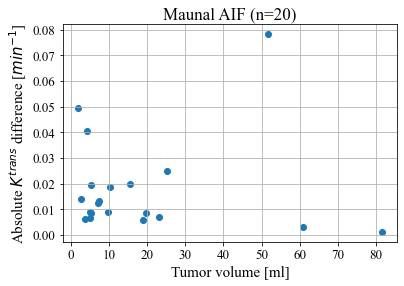

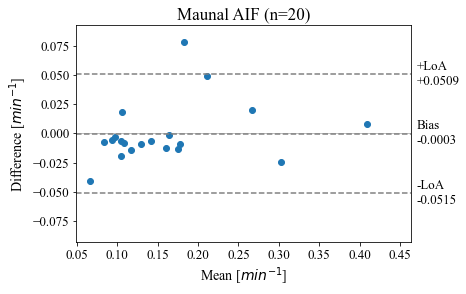

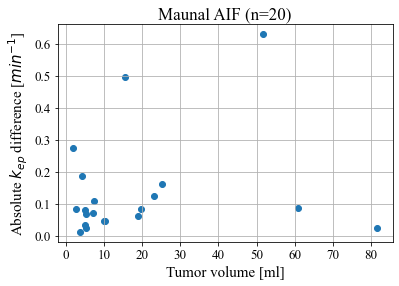

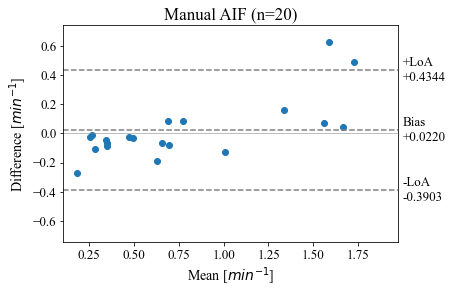

In [6]:
'''
Plotting the difference in Ktrans values from average and voxelwise modelling versus the tumor volume
'''
f_avr = open('H:/data/Results/ManualAIF/output_average.json')
f_vox = open('H:/data/Results/ManualAIF/output_voxelwise.json')

avr_data = json.load(f_avr)
vox_data = json.load(f_vox)

Kt_diff = []
Kt_avrg = []
Kt_voxel = []
kep_avrg = []
kep_voxel = []
ve_avrg = []
ve_voxel = []
vp_avrg = []
vp_voxel = []
tumor_vol = []

for i in range(0,len(vox_data)): 
    tumor_vol.append(avr_data[i]['tumor_volume'])
    Kt_avrg.append(avr_data[i]['Ktrans']*60)
    Kt_voxel.append(vox_data[i]['Ktrans']*60)
    diff = abs(vox_data[i]['Ktrans']*60 - avr_data[i]['Ktrans']*60)
    Kt_diff.append(diff)
    kep_avrg.append(avr_data[i]['kep']*60)
    kep_voxel.append(vox_data[i]['kep']*60)
    ve_avrg.append(avr_data[i]['ve'])
    ve_voxel.append(vox_data[i]['ve'])
    vp_avrg.append(avr_data[i]['vp'])
    vp_voxel.append(vox_data[i]['vp'])

#Mean and standard deviation
print('Kt:', np.array(Kt_avrg).mean(), 'std:', np.array(Kt_avrg).std())

#Medain and range
print('Median Kt:', np.median(Kt_avrg), min(Kt_avrg), max(Kt_avrg))

vol_arr = np.array(tumor_vol)*0.001 #from mm^3 to ml
sort_vol = np.sort(vol_arr)
sort_index = np.argsort(vol_arr)

res = [val for (_, val) in sorted(zip(sort_index, Kt_diff), key=lambda x: x[0])]

#Absolute Kt difference plotted against tumor volume
fig1 = plt.figure(1)
plt.rcParams['font.family'] = 'Times New Roman'
plt.scatter(sort_vol, res)
plt.xlabel('Tumor volume [ml]', size=label_fontsize)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.ylabel('Absolute $K^{trans}$ difference [$min^{-1}$]', size=label_fontsize)
plt.title('Maunal AIF (n=20)', size=title_fontsize)
plt.grid()
fig1.savefig('H:/data/Results/ManualAIF/tumorvol_vs_Ktdiff_manualAIF.eps', bbox_inches='tight')

#Ktrans Bland-Altman 
fig2 = plt.figure(2)
bland_altman_plot(Kt_avrg, Kt_voxel, 0.47)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.title('Maunal AIF (n=20)', size=title_fontsize)
fig2.savefig('H:/data/Results/ManualAIF/Bland_altman_manualAIF.eps', bbox_inches='tight')

#Plot absolute kep difference against tumor volume
kep_diff = abs(np.asarray(kep_avrg) - np.asarray(kep_voxel))
fig3 = plt.figure(3)
plt.rcParams['font.family'] = 'Times New Roman'
plt.scatter(vol_arr, kep_diff)
plt.xlabel('Tumor volume [ml]', size=label_fontsize)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.ylabel('Absolute $k_{ep}$ difference [$min^{-1}$]', size=label_fontsize)
plt.title('Maunal AIF (n=20)', size=title_fontsize)
plt.grid()
fig3.savefig('H:/data/Results/ManualAIF/tumorvol_vs_kepdiff_manualAIF.eps', bbox_inches='tight')

#kep Bland-Altman plot
fig4 = plt.figure(4)
bland_altman_plot(kep_avrg, kep_voxel, 2)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.title('Manual AIF (n=20)', size=title_fontsize)
fig4.savefig('H:/data/Results/ManualAIF/Bland_altman_manualAIF_kep.eps', bbox_inches='tight')

#Pearson correlation 
pearson = stats.pearsonr(np.asarray(Kt_avrg), np.asarray(Kt_voxel))
#Spearman correlation 
spearman = stats.spearmanr(np.asarray(Kt_avrg), np.asarray(Kt_voxel))


#Kolmogorov-Smirnov to test if the data is normally distributed 
ks_result = kstest(Kt_avrg, cdf = 'norm')
if ks_result[1] > 0.05: #t-test if the data is normally distributed 
    print(f"K-S statistic: {ks_result[0]}")
    print(f"p-value: {ks_result[1]}")
    t_test = stats.ttest_rel(np.asarray(Kt_avrg), np.asarray(Kt_voxel))
    print(t_test)
else: #Wilcoxon signed-rank test if the data is not normally distributed 
    print('Data is not normally distributed')
    print(f"K-S statistic: {ks_result[0]}")
    print(f"p-value: {ks_result[1]}")
    res  = wilcoxon(np.array(Kt_avrg), np.array(Kt_voxel))
    print('Wilcoxon p-value:', res.pvalue)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Kt mean: 0.28454432720272194 Percent: 120.10745372448835 Max: 1.5116646537364693 Max percent: 258.72343735580813 Min: 0.013736669308119391 Min percent: 22.99138900780703
Bias percent: -32.173980345127106
PearsonRResult(statistic=-0.10362662500685355, pvalue=0.682398619439848)
SpearmanrResult(correlation=-0.2528379772961816, pvalue=0.31141340050989863)
Data is not normally distributed
K-S statistic: 0.5185693464996767
p-value: 5.010975562785189e-05
Wilcoxon p-value: 0.6396942138671875
Wilcoxon z-statistic: 74.0


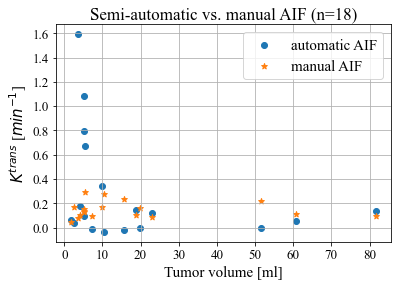

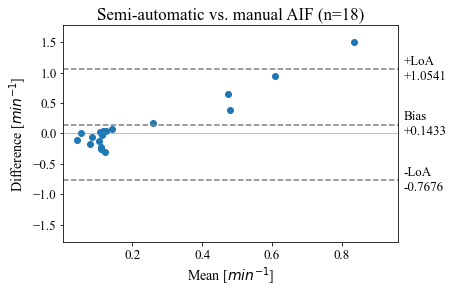

In [7]:
#Analysed differences between manual AIF and semi-automatic AIF
f_auto = open('H:/data/Results/AutoAIF/3percent/output_average.json')
f_man = open('H:/data/Results/ManualAIF/output_average.json')

auto_data = json.load(f_auto)
man_data = json.load(f_man)

Kt_auto = []
Kt_man = []
kep_auto = []
kep_man = []
ve_auto = []
ve_man = []
vp_auto = []
vp_man = []
tumor_vol = []

for i in range(len(man_data)): 
    for j in range(len(auto_data)): 
        if auto_data[j]['patientID'] == man_data[i]['patientID']: 
            tumor_vol.append(auto_data[j]['tumor_volume'])
            Kt_auto.append(auto_data[j]['Ktrans']*60)
            Kt_man.append(man_data[i]['Ktrans']*60)
            kep_auto.append(auto_data[j]['kep']*60)
            kep_man.append(man_data[i]['kep']*60)
            ve_auto.append(auto_data[j]['ve'])
            ve_man.append(man_data[i]['ve'])
            vp_auto.append(auto_data[j]['vp'])
            vp_man.append(man_data[i]['vp'])
            
vol_arr = np.array(tumor_vol)
sort_vol = np.sort(vol_arr)
sort_index = np.argsort(vol_arr)
Kt_diff = abs(np.asarray(Kt_auto) - np.asarray(Kt_man))
res = [val for (_, val) in sorted(zip(sort_index, Kt_diff), key=lambda x: x[0])]

#Plot 
fig1 = plt.figure(1)
plt.rcParams.update({'font.family':'Times New Roman'})
plt.scatter(tumor_vol, Kt_auto, label='automatic AIF', color='tab:blue')
plt.scatter(tumor_vol, Kt_man, label='manual AIF', color='tab:orange', marker='*')
plt.legend(fontsize=label_fontsize)
plt.xticks(size=tick_size)
plt.yticks(size=tick_size)
plt.xlabel('Tumor volume [ml]', size=label_fontsize)
plt.ylabel('$K^{trans}$ [$min^{-1}$]', size=label_fontsize)
plt.title('Semi-automatic vs. manual AIF (n=18)', size=title_fontsize)
plt.grid()
fig1.savefig('H:/data/Results/Ktman_vs_Kt_auto.eps', bbox_inches='tight')

Kt_percent = []
kep_percent = []
ve_percent = []
vp_percent = []
for i in range(len(Kt_man)): 
    Kt_percent.append(((abs(Kt_auto[i] - Kt_man[i]))/((Kt_auto[i] + Kt_man[i])/2) * 100))
    kep_percent.append(((abs(kep_auto[i] - kep_man[i]))/((kep_auto[i] + kep_man[i])/2) * 100))
    ve_percent.append(((abs(ve_auto[i] - ve_man[i]))/((ve_auto[i] + ve_man[i])/2) * 100))
    vp_percent.append(((abs(vp_auto[i] - vp_man[i]))/((vp_auto[i] + vp_man[i])/2) * 100))


print('Kt mean:', Kt_diff.mean(), 'Percent:', np.mean(Kt_percent), 'Max:', Kt_diff.max(), 'Max percent:', np.max(Kt_percent), 'Min:', Kt_diff.min(), 'Min percent:', np.min(Kt_percent))

#Bland-Altman 
fig2 = plt.figure(2)
bland_altman_plot(Kt_auto, Kt_man, 0.978)
plt.xticks(size=tick_size)
plt.yticks(size=tick_size)
plt.title('Semi-automatic vs. manual AIF (n=18)', size=title_fontsize)
fig2.savefig('H:/data/Results/Bland_altman_manvsautoAIF.eps', bbox_inches='tight')

#Pearson correlation 
pearson = stats.pearsonr(np.asarray(Kt_man), np.asarray(Kt_auto))
print(pearson)
#Spearman correlation
spearman = spearmanr(np.asarray(Kt_man), np.asarray(Kt_auto))
print(spearman)

#Kolmogorov-Smirnov to test if the data is normally distributed 
ks_result = kstest(Kt_man, cdf = 'norm')
if ks_result[1] > 0.05: #t-test if the data is normally distributed 
    print(f"K-S statistic: {ks_result[0]}")
    print(f"p-value: {ks_result[1]}")
    t_test = stats.ttest_rel(np.asarray(Kt_man), np.asarray(Kt_auto))
    print(t_test)
else: 
    print('Data is not normally distributed')
    print(f"K-S statistic: {ks_result[0]}")
    print(f"p-value: {ks_result[1]}")
    #mann_whitney = mannwhitneyu(np.array(Kt_avrg), np.array(Kt_voxel))
    #print(mann_whitney)
    res  = wilcoxon(np.asarray(Kt_man), np.asarray(Kt_auto))
    print('Wilcoxon p-value:', res.pvalue)
    print('Wilcoxon z-statistic:', res.statistic)
    

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


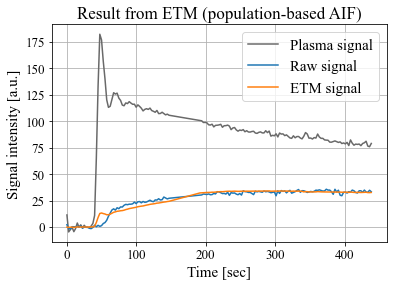

In [10]:
#Tofts method for one patient and generating plot ETM results 
#population-based AIF
from imagedata import Series
import os 
import numpy as np
import matplotlib.pyplot as plt
from readdata import *
from tofts_method import *
from numpy import loadtxt

path = 'H:/data/master endometrial data/198/'
dce_path = os.path.join(path, 'dce')
mask_path = os.path.join(path, 'mask')

#Read and align data
MASK, DCE, timeline = readdata(mask_path, dce_path, 'mask2dce')

# load aif array
aif = loadtxt('H:/data/master endometrial data/Pop_AIF/aif_data3.csv', delimiter=',')
cp = aif/(1-0.42) #42 percent Hematocrit

patientID = DCE.patientID

#Find pixel and voxel size
spacing = DCE.spacing
z = spacing[0]
y = spacing[1]
x = spacing[2]
pixel_size = x*y
voxel_size = x*y*z
voxel_ml = voxel_size*0.001 #milliliter

#Subtract pre-contrast signal from signal
DCE = DCE.astype('float32')
S0 = np.mean(DCE[0:5,:,:,:], axis=0)
dynim = DCE.copy()
for k in range(len(timeline)):
    dynim[k,:,:,:] = DCE[k,:,:,:] - S0
    
#Finding mean concentration inside mask 
non_zero_in_mask = np.nonzero(MASK) #index of nonzero elements in mask image
in_mask_vals = dynim[:, non_zero_in_mask[0], non_zero_in_mask[1], non_zero_in_mask[2]]
C = np.asarray(np.mean(in_mask_vals, axis=1), dtype='float')
opt_params, C_tofts = run_tofts(timeline, C, cp)
tumor_vol = in_mask_vals.shape[1]*voxel_ml
opt_params['patientID'] = patientID
opt_params['tumor_volume'] = tumor_vol

#Plot results together with raw concentration and plasma concentration 
#Plot results together with raw concentration and plasma concentration 

# change the default font family
plt.rcParams.update({'font.family':'Times New Roman'})
plt.plot(timeline, cp, label='Plasma signal', color='dimgrey')
plt.plot(timeline,C, label='Raw signal', color='tab:blue')
plt.plot(timeline, C_tofts, label='ETM signal', color='tab:orange')
plt.grid()
plt.xticks(size=tick_size)
plt.yticks(size=tick_size)
plt.legend(fontsize=label_fontsize)
plt.title('Result from ETM (population-based AIF)', size=title_fontsize)
plt.xlabel('Time [sec]', size=label_fontsize)
plt.ylabel('Signal intensity [a.u.]', size=label_fontsize)
plt.savefig('H:/data/master endometrial data/198/ETMplot_p198_popAIF.eps', bbox_inches='tight')